## Accessing DM-EFD data


In this notebook we demonstrate how to extract data from the DM-EFD using [aioinflux](https://aioinflux.readthedocs.io/en/stable/index.html), a Python client for InfluxDB, and proceed with data analysis using Pandas dataframes. 

This is complementaty to the [Chronograf](https://test-chronograf-efd.lsst.codes) interface which we use for time-series visualization.

In addition to `aioinflux`, you'll need to install `pandas`, `numpy` and `matplotlib` to run this notebook.

In [147]:
import matplotlib
%matplotlib widget
%matplotlib inline
from matplotlib import pylab as plt
import aioinflux
import getpass
import pandas as pd
import asyncio

import datashader.transfer_functions as tf
import datashader as ds

from bokeh.models import BoxZoomTool, DatetimeTickFormatter
from datashader.bokeh_ext import InteractiveImage
import bokeh.plotting as bp
bp.output_notebook()

Loading BokehJS ...

We'll access the DM-EFD instance deployed at the AuxTel lab in Tucson. You need to be on site or connected to the NOAO VPN. 

If you are familiar with the AuxTel lab environment, you might be able to authenticate using the generic `saluser`. Ping me at Slack (`@afausti`) if you have any problem.

In [2]:
username = "saluser"
password = getpass.getpass(f"Password for {username}:")

Password for saluser: ········


The following configures the `aioinflux` Python client to connect to the DM-EFD InfluxDB instance. 

In [3]:
client = aioinflux.InfluxDBClient(host='summit-influxdb-efd.lsst.codes', 
                                  port='443', 
                                  ssl=True, 
                                  username=username, 
                                  password=password,
                                  db='efd')

We can configure the output to be a Pandas dataframe, which is very convenient for data analysis.  Specify a time range for data in `InfluxQL`.  The default is 20hrs ago, but this may need to be changed depending on how recently data was taken.

In [61]:
client.output = 'dataframe'
#time_span = "time >= '2019-09-07T21:30:00Z' AND time < '2019-09-08T06:00:00Z'"
time_span = "time >= '2019-09-08T01:42:00Z' AND time <= '2019-09-08T01:42:20Z'"

Query each of the measurements we may want to correlate later in the notebook.  Note that this could be done as a single query, but the result is a dictionary of `DataFrames` which I find less convenient to use than named variables corresponding to one `DataFrame` each.

In [62]:
async def get_data_frame(field_base, topic, els=100):
    fields = ", ".join([f'"{field_base}{i}"' for i in range(100)])
    df = await client.query(f'SELECT "cRIO_timestamp", "private_sndStamp", {fields} FROM "efd"."autogen"."{topic}" WHERE {time_span}')

    times = []
    timestamps = []
    vals = []
    step = 1./els
    for row in df.itertuples():
        for i in range(els):
            times.append(row.cRIO_timestamp + i*step)
            timestamps.append((pd.Timestamp(row.cRIO_timestamp, unit='s', tz='GMT') + pd.Timedelta(i*step, unit='s')))
            vals.append(getattr(row, f'{field_base}{i}'))

    return pd.DataFrame({'times':times, field_base:vals}, index=timestamps)

In [63]:
az = await get_data_frame('azimuthCalculatedAngle', 'lsst.sal.ATMCS.mount_AzEl_Encoders')

In [64]:
measured_vel_az1 = await get_data_frame('azimuthMotor1Velocity', 'lsst.sal.ATMCS.measuredMotorVelocity')
measured_vel_az2 = await get_data_frame('azimuthMotor2Velocity', 'lsst.sal.ATMCS.measuredMotorVelocity')

In [65]:
commanded_az = await get_data_frame('azimuth', 'lsst.sal.ATMCS.trajectory')
commanded_az_vel = await get_data_frame('azimuthVelocity', 'lsst.sal.ATMCS.trajectory')

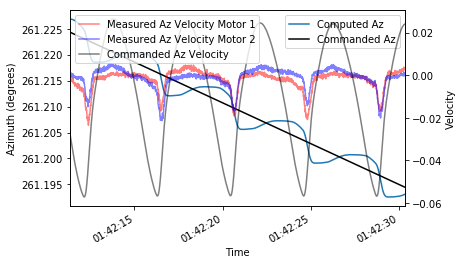

In [156]:
p1 = az.plot(y='azimuthCalculatedAngle', label='Computed Az')
p2 = p1.twinx()
p1.set_xlabel('Time')
p1.set_ylabel('Azimuth (degrees)')
p2.set_ylabel('Velocity')
p2.plot(measured_vel_az1.index.values, measured_vel_az1['azimuthMotor1Velocity'], c='r', alpha=0.5, label="Measured Az Velocity Motor 1")
p2.plot(measured_vel_az2.index.values, measured_vel_az2['azimuthMotor2Velocity'], c='b', alpha=0.5, label="Measured Az Velocity Motor 2")
p2.plot(commanded_az_vel.index.values, commanded_az_vel['azimuthVelocity'], c='black', alpha=0.5, label="Commanded Az Velocity")
p1.plot(commanded_az.index.values, commanded_az['azimuth'], c='black', label="Commanded Az")
p1.legend(loc='upper right')
p2.legend(loc='upper left')

In [128]:
el = await get_data_frame('elevationCalculatedAngle', 'lsst.sal.ATMCS.mount_AzEl_Encoders')

In [129]:
measured_el_vel = await get_data_frame('elevationMotorVelocity', 'lsst.sal.ATMCS.measuredMotorVelocity')
commanded_el = await get_data_frame('elevation', 'lsst.sal.ATMCS.trajectory')
commanded_el_vel = await get_data_frame('elevationVelocity', 'lsst.sal.ATMCS.trajectory')

In [130]:
commanded_el.columns

Index(['times', 'elevation'], dtype='object')

In [132]:
el.elevationCalculatedAngle.values-commanded_el.elevation.values[200::]

array([0.00356068, 0.00356057, 0.00356046, ..., 0.00357362, 0.00357396,
       0.00357027])

In [151]:
# find time offset between datasets
commanded_el.times.values[100]-el.times.values[0]

0.0

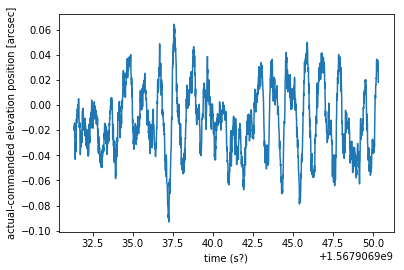

In [155]:
y=commanded_el.times.values[100:-100]
x=(el.elevationCalculatedAngle.values-commanded_el.elevation.values[100:-100])*3600
plt.plot(y, x)
plt.ylabel('actual-commanded elevation position [arcsec]')
plt.xlabel('time (s?)')
plt.show();

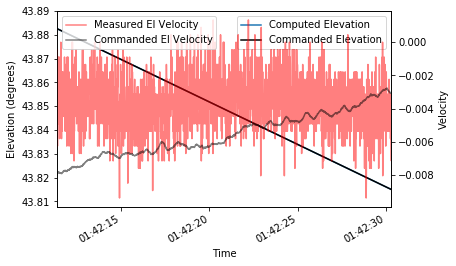

In [157]:
p1 = el.plot(y='elevationCalculatedAngle', label='Computed Elevation')
p2 = p1.twinx()
p1.set_xlabel('Time')
p1.set_ylabel('Elevation (degrees)')
p2.set_ylabel('Velocity')
p2.plot(measured_el_vel.index.values, measured_el_vel['elevationMotorVelocity'], c='r', alpha=0.5, label="Measured El Velocity")
p2.plot(commanded_el_vel.index.values, commanded_el_vel['elevationVelocity'], c='black', alpha=0.5, label="Commanded El Velocity")
p1.plot(commanded_el.index.values, commanded_el['elevation'], c='black', label="Commanded Elevation")
p1.legend(loc='upper right')
p2.legend(loc='upper left')

In [79]:
measured_el_vel.index.values[0::]-commanded_el_vel.index.values[100::]

array([0, 0, 0, ..., 0, 0, 0], dtype='timedelta64[ns]')